In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
Asset_PATH = "/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/"

#### Load Gaussian KDE timeseries

In [3]:
density_matrix_t_series = pickle.load(open(Asset_PATH  + 'density_matrix_t_series_100x100.pickle', 'rb'))

In [4]:
density_matrix_t_series.shape

(198, 100, 100)

In [5]:
print(np.max(density_matrix_t_series))
print(np.min(density_matrix_t_series))

2019.7794007598727
-2.393156546274511e-13


In [6]:
density_matrix_t_series.shape[0]

198

In [7]:
timesteps = 52

In [8]:
train, valid = (60,20)
test = 20

total_len = density_matrix_t_series.shape[0] - timesteps
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

In [9]:
flattened_matrix_np = np.reshape(density_matrix_t_series, 
                                 (density_matrix_t_series.shape[0],
                                  density_matrix_t_series.shape[1]*density_matrix_t_series.shape[2]))
flattened_matrix_np.shape

(198, 10000)

In [10]:
np.max(flattened_matrix_np[train_index])

1935.6194220503628

In [11]:
scaler_max = np.max(flattened_matrix_np[train_index])
scaler_min = np.min(flattened_matrix_np[train_index])

X_train = (flattened_matrix_np[train_index] - scaler_min)/(scaler_max - scaler_min)


In [12]:
X_train = X_train.reshape(X_train.shape[0],
                          1,    
                          X_train.shape[1])
X_train.shape

(87, 1, 10000)

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],int(X_train.shape[2]**(1/2)),int(X_train.shape[2]**(1/2)),1)
X_train.shape

(87, 1, 100, 100, 1)

In [14]:
print(np.max(X_train))
print(np.min(X_train))

1.0
0.0


#### We transform the whole train, valid, test based on scaler fitted on train

In [15]:
np.max(flattened_matrix_np)

2019.7794007598727

In [16]:
flattened_matrix_np.dtype

dtype('float64')

In [17]:
scaled_flattened_matrix = (flattened_matrix_np - scaler_min)/(scaler_max - scaler_min)

In [18]:
flattened_matrix_np.shape

(198, 10000)

In [19]:
scaled_flattened_matrix.shape

(198, 10000)

In [20]:
print(np.max(scaled_flattened_matrix))
print(np.min(scaled_flattened_matrix))

1.0434796105839654
-3.2227207716804404e-17


In [21]:
scaled_flattened_matrix.shape

(198, 10000)

In [22]:
def window_stack(a, stepsize=1, width=52):
    n = a.shape[0]
    return np.hstack( a[i:1+n+i-width:stepsize] for i in range(0,width) )

In [23]:
stacked = window_stack(scaled_flattened_matrix,1,timesteps)

/home/zhimin90/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
stacked.shape

(147, 520000)

In [25]:
reshape_stack = stacked.reshape(stacked.shape[0],timesteps,
                                int((stacked.shape[1]/timesteps)**(1/2)),
                                int((stacked.shape[1]/timesteps)**(1/2)),1)

In [26]:
reshape_stack.shape

(147, 52, 100, 100, 1)

#### We reshape to (sample, timestep, inputshape)

In [27]:
scaled_flattened_matrix = reshape_stack
scaled_flattened_matrix.shape

(147, 52, 100, 100, 1)

In [28]:
train, valid = (60,20)
test = 20

total_len = scaled_flattened_matrix.shape[0]
train_index = range(0,int(train/100*total_len))

valid_index = range(train_index[-1]+1,train_index[-1] + int(valid/100*total_len))
test_index = range(valid_index[-1]+1,valid_index[-1] + int(test/100*total_len))

#### We set the target to be 7 days aggregated KDE or 1 single frame forward

In [29]:
X_train = scaled_flattened_matrix[np.array(train_index)]
Y_train = scaled_flattened_matrix[np.array(train_index)+1][:,-1,:]
Y_train = Y_train.reshape(Y_train.shape[0],int(Y_train.shape[1]*Y_train.shape[2]*Y_train.shape[3]))

In [30]:
X_valid = scaled_flattened_matrix[np.array(valid_index)]
Y_valid = scaled_flattened_matrix[np.array(valid_index)+1][:,-1,:]
Y_valid = Y_valid.reshape(Y_valid.shape[0],int(Y_valid.shape[1]*Y_valid.shape[2]*Y_valid.shape[3]))

In [31]:
X_test = scaled_flattened_matrix[np.array(test_index)]
Y_test = scaled_flattened_matrix[np.array(test_index)+1][:,-1,:]
Y_test = Y_test.reshape(Y_test.shape[0],int(Y_test.shape[1]*Y_test.shape[2]*Y_test.shape[3]))

In [32]:
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape)
print(Y_test.shape)

(88, 52, 100, 100, 1)
(88, 10000)
(28, 52, 100, 100, 1)
(28, 10000)
(28, 52, 100, 100, 1)
(28, 10000)


In [33]:
import os, datetime
import tensorflow as tf
from tensorflow.keras import optimizers
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, GaussianNoise, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, LSTM, GRU, RepeatVector, TimeDistributed
from tensorflow.keras.layers import concatenate, Activation, Permute, Multiply, Lambda


In [34]:
checkpoint_filepath = Asset_PATH+'checkpoints/'
print(checkpoint_filepath)

/home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/


## Flattened Fully Connected Model

In [86]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))
   
timeDist = TimeDistributed(Flatten())(inputs)

Dense1 = Dense(50, kernel_initializer='glorot_normal', activation='relu')(timeDist)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_Fully_Connected")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


Model: "Flattened_Fully_Connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_31 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
dense_38 (Dense)             (None, 52, 50)            500050    
_________________________________________________________________
flatten_31 (Flatten)         (None, 2600)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 10000)             26010000  
Total params: 26,510,050
Trainable params: 26,510,050
Non-trainable params: 0
_________________________________________________________________


## Flattened LSTM Model

In [65]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

    
timeDist = TimeDistributed(Flatten())(inputs)

LSTM_layer1 = LSTM(100)(timeDist)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="Flattened_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "Flattened_LTSM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 52, 100, 100, 1)] 0         
_________________________________________________________________
time_distributed_16 (TimeDis (None, 52, 10000)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               4040400   
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
flatten_21 (Flatten)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 10000)             1010000   
Total params: 5,060,500
Trainable params: 5,060,500
Non-trainable params: 0
__________________________________________

## 2D CNN LSTM model

In [73]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
batch = 48
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'

inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(20, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(20, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])

LSTM_layer1 = LSTM(50)(merge)
Dense1 = Dense(100, kernel_initializer='glorot_normal', activation='relu')(LSTM_layer1)
Dense2 = Dense(Y_train.shape[1])(Flatten()(Dense1))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)



Model: "2DCNN_LTSM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_18 (TimeDistri (None, 52, 100, 100, 40          input_9[0][0]                    
__________________________________________________________________________________________________
time_distributed_19 (TimeDistri (None, 52, 100, 100, 420         time_distributed_18[0][0]        
__________________________________________________________________________________________________
time_distributed_20 (TimeDistri (None, 52, 50, 50, 2 0           time_distributed_19[0][0]        
_________________________________________________________________________________________

## 2D CNN with LSTM + Attention

In [35]:
from tensorflow.keras import backend as K

In [75]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

cnn1 = Conv2D(10, (1,1), activation='relu', padding='same')
TD = TimeDistributed(cnn1)(inputs)

cnn2 = Conv2D(10, (1,1), activation='relu', padding='same')
TD2 = TimeDistributed(cnn2)(TD)

TD3 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD2)
    
timeDist = TimeDistributed(Flatten())(TD3)

'''
#Paralell 2D CNN layer
cnn4 = Conv2D(20, (1,1), activation='relu', padding='same')
TD4 = TimeDistributed(cnn4)(TD3)

cnn5 = Conv2D(20, (1,1), activation='relu', padding='same')
TD5 = TimeDistributed(cnn5)(TD4)

TD6 = TimeDistributed(
        MaxPooling2D(pool_size=(2, 2)))(TD5)
    
timeDist2 = TimeDistributed(Flatten())(TD6)

merge = concatenate([timeDist, timeDist2])
'''

#send both convolved layer and flattened layer into LSTM
#merge = concatenate([timeDist, timeDist3])

units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#For each timestep update a single weight on Dense layer
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention shape (None, 52, 100)
LSTM_layer1 shape (None, 52, 100)
sent_representation shape (None, 52, 100)
Model: "2DCNN_LTSM_Attention"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_26 (TimeDistri (None, 52, 100, 100, 20          input_10[0][0]                   
__________________________________________________________________________________________________
time_distributed_27 (TimeDistri (None, 52, 100, 100, 110         time_distributed_26[0][0]        
__________________________________________________________________________________________________
time_distributed_28 (TimeDistri (None, 52, 50, 50, 1 0           time_

## Flattened LSTM + Attention

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

#send both convolved layer and flattened layer into LSTM
timeDist3 = TimeDistributed(Flatten())(inputs)
#merge = concatenate([timeDist, timeDist3])

units = 100
LSTM_layer1 = LSTM(units, return_sequences=True)(timeDist3)

# compute importance for each step
attention = Dense(units, activation='tanh')(LSTM_layer1) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)

#attention = Dense(1, activation='tanh')(LSTM_layer1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)

print("attention shape", attention.shape)
print("LSTM_layer1 shape", LSTM_layer1.shape)
sent_representation = Multiply()([LSTM_layer1, attention])

print("sent_representation shape", sent_representation.shape)
#same shape as LSTM output (None,52,100)

#For each timestep update a single weight on Dense layer
attended_LSTM_out = TimeDistributed(Dense(3, activation='relu'))(sent_representation)

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(attended_LSTM_out))
outputs = Dense2

model = Model(inputs, outputs, name="2DCNN_LTSM_Attention")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


## Attention on flattened inputs

In [61]:
serie_size, time_step, n_features_row, n_features_column, no_channel = X_train.shape

epochs = 100
lr = .0001
loss='mae'
METRIC_ACCURACY = 'mae'


inputs = Input(shape=(time_step,n_features_row, n_features_column, no_channel))

timeDist = TimeDistributed(Flatten())(inputs)
timeDist2 = TimeDistributed(Dense(25))(timeDist)
units = timeDist2.shape[2]
# compute importance for each step
attention = Dense(units, activation='tanh')(timeDist2) ## weight matrix W (= units x units)
attention = Dense(1, activation='linear')(attention)     ## weight matrix v (= units x 1)
#attention = Dense(1, activation='tanh')(timeDist2)
print('attention.shape: ', attention.shape)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = Multiply()([timeDist2, attention])
#For each timestep update a single weight on Dense layer
attended_Dense_out = TimeDistributed(Dense(1, activation='relu'))(sent_representation)

timeDist3 = TimeDistributed(Flatten())(inputs)
timeDist4 = TimeDistributed(Dense(25))(timeDist3)
units = timeDist4.shape[2]
# compute importance for each step
attention2 = Dense(units, activation='tanh')(timeDist4) ## weight matrix W (= units x units)
attention2 = Dense(1, activation='linear')(attention2)     ## weight matrix v (= units x 1)
#attention2 = Dense(1, activation='tanh')(timeDist4)
attention2 = Flatten()(attention2)
attention2 = Activation('softmax')(attention2)
attention2 = RepeatVector(units)(attention2)
attention2 = Permute([2, 1])(attention2)
sent_representation2 = Multiply()([timeDist4, attention2])
#For each timestep update a single weight on Dense layer
attended_Dense_out2 = TimeDistributed(Dense(1, activation='relu'))(sent_representation2)
'''
timeDist5 = TimeDistributed(Flatten())(inputs)
timeDist6 = TimeDistributed(Dense(20))(timeDist5)
units = timeDist6.shape[2]
# compute importance for each step
attention3 = Dense(1, activation='tanh')(timeDist6)
attention3 = Flatten()(attention3)
attention3 = Activation('softmax')(attention3)
attention3 = RepeatVector(units)(attention3)
attention3 = Permute([2, 1])(attention3)
sent_representation3 = Multiply()([timeDist6, attention3])
#For each timestep update a single weight on Dense layer
attended_Dense_out3 = TimeDistributed(Dense(1, activation='relu'))(sent_representation3)
'''
merge = concatenate([attended_Dense_out, attended_Dense_out2])

#Flatten time dimension
Dense2 = Dense(Y_train.shape[1])(Flatten()(merge))
outputs = Dense2

model = Model(inputs, outputs, name="Attention_Time")
model.summary()

adam = optimizers.Adam(lr)
model.compile(loss='mean_absolute_error',
                   metrics=['mae'], 
                   optimizer=adam)


attention.shape:  (None, 52, 1)
Model: "Attention_Time"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 52, 100, 100 0                                            
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, 52, 10000)    0           input_6[0][0]                    
__________________________________________________________________________________________________
time_distributed_13 (TimeDistri (None, 52, 10000)    0           input_6[0][0]                    
__________________________________________________________________________________________________
time_distributed_11 (TimeDistri (None, 52, 25)       250025      time_distributed_10[0][0]        
_____________________________________________________

## Run fit on any of the previous model here

In [89]:
EPOCHS = 5

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=EPOCHS*10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,)

logdir = os.path.join("./logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_cbk = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelfilename = checkpoint_filepath + '_'+\
                    datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\
                    + "_model.hdf5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    modelfilename,
    save_weights_only=False,
    monitor='val_loss',#'val_accuracy',
    mode='min',
    verbose=1,
    period = 1,
    save_best_only=True)



model_history = model.fit(X_train,Y_train, 
                             validation_data=(X_valid, Y_valid),
                             epochs=1000, 
                             batch_size=7, 
                             callbacks=[tensorboard_cbk,
                             #hp.KerasCallback(logdir, hparams),
                             earlystop_callback,
                             model_checkpoint_callback
                                       ]
                                   )
valid_loss, valid_acc = model.evaluate(X_valid, Y_valid, verbose=2) # 5/2020 nt: use validation set
print ("valid_accuracy_MAE=%s, valid_loss=%s" % (valid_acc, valid_loss))

Train on 88 samples, validate on 28 samples
Epoch 1/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00001: val_loss improved from inf to 0.00170, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200627-101701_model.hdf5
88/88 [==============================] - 1s 7ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 2/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00002: val_loss improved from 0.00170 to 0.00170, saving model to /home/zhimin90/DePaul/CSC695/Github/CSC695-Masters-Research-on-Neural-Network-Time-Series-Attention-Models/Asset/checkpoints/_20200627-101701_model.hdf5
88/88 [==============================] - 1s 8ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 3/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.

Epoch 27/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00027: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 28/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00028: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 29/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00029: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 30/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00030: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.

63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00058: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 59/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00059: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 60/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00060: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0017 - val_mae: 0.0017
Epoch 61/1000
63/88 [====================>.........] - ETA: 0s - loss: 0.0016 - mae: 0.0016
Epoch 00061: val_loss did not improve from 0.00170
88/88 [==============================] - 0s 2ms/sample - loss: 0.0016 - mae: 0.

#### Adam Optimize:

### Best flatten() + fully connected Dense is at  MAE of 0.001698

### Best flatten() + LSTM(100) is at  MAE of 0.001731

### Best 2D CNN + LSTM(50) is at MAE of 0.001724

### Best 2D CNN + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.0016917

### Best flatten() + LSTM(100) + Attention on LSTM recurrences is at  MAE of 0.001692

### Best flatten() + 2x Attention Heads on  TimeDistributed is at MAE of 0.0016914

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

In [43]:
Predict = model.predict(X_valid)

In [44]:
Predict.shape

(28, 10000)

In [45]:
int(Predict[-1].shape[0]**(1/2)),int(Predict[-1].shape[0]**(1/2))

(100, 100)

In [46]:
def reshapePred(Predict, fromLast=1):
    return np.rot90(Predict[-1*fromLast].reshape(int(Predict[-1*fromLast].shape[0]**(1/2)),int(Predict[-1*fromLast].shape[0]**(1/2))))

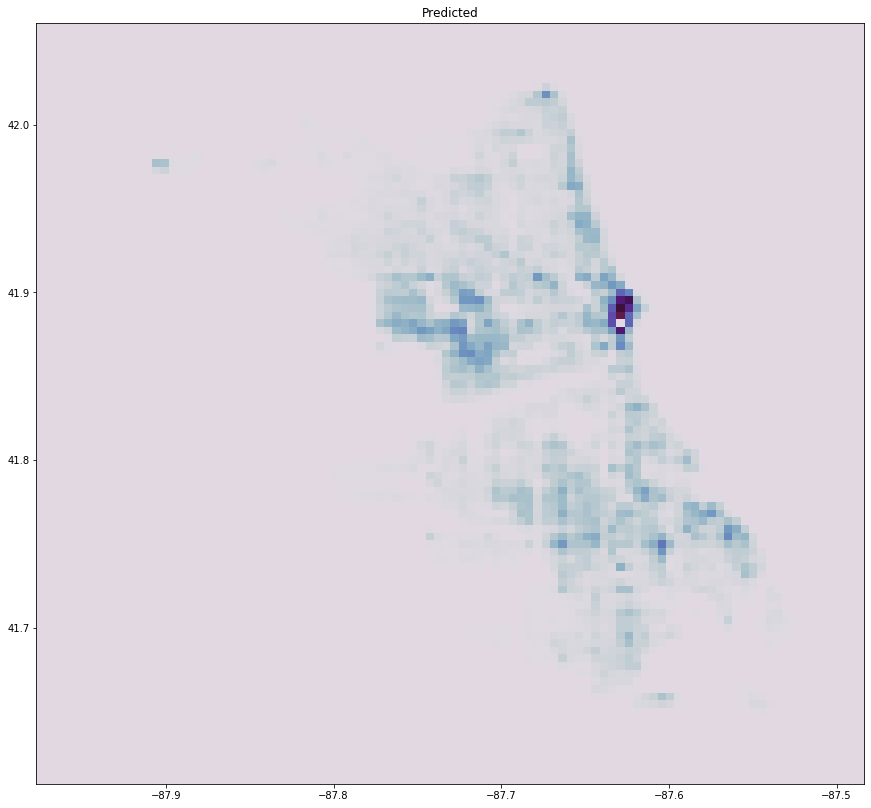

In [79]:
import matplotlib.pyplot as plt
grid_size = 500
density_matrix_t_series = []
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
plt.figure(figsize=(18, 14))
plt.title('Predicted')
plt.imshow( X=reshapePred(Predict,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

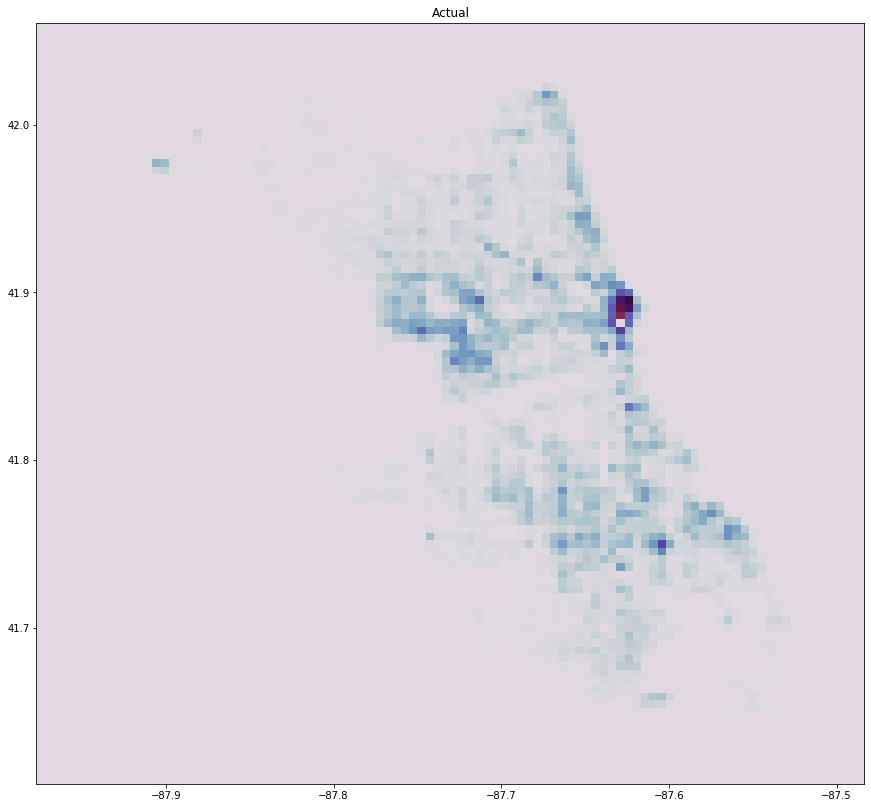

In [80]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=reshapePred(Y_valid,1), cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### We plot the difference between prediction and target

In [81]:
diff = (reshapePred(Y_valid,3)-reshapePred(Predict,3))
diff.shape

(100, 100)

In [82]:
diff_max = np.max(diff)
diff_min = np.min(diff)
scaled_diff = (diff - diff_min)/(diff_max - diff_min)

In [83]:
np.max(scaled_diff)

1.0

In [84]:
diff

array([[-7.58956958e-07,  7.58956958e-07,  7.58956958e-07, ...,
         7.58956958e-07,  7.58956958e-07, -3.56662395e-06],
       [-7.58956958e-07,  7.58956958e-07, -7.58956958e-07, ...,
        -7.58956958e-07,  7.58956958e-07, -7.58956958e-07],
       [ 3.13577948e-05,  3.56663850e-06,  7.58956958e-07, ...,
         7.58956958e-07,  7.58956958e-07, -7.58956958e-07],
       ...,
       [ 7.58956958e-07,  7.58956958e-07,  3.56663850e-06, ...,
        -3.13577948e-05,  7.58956958e-07, -7.58956958e-07],
       [ 7.58956958e-07, -7.58956958e-07, -1.20610002e-05, ...,
         7.58956958e-07, -7.58956958e-07, -7.58956958e-07],
       [ 1.20610002e-05,  7.58956958e-07,  7.58956958e-07, ...,
         7.58956958e-07, -7.58956958e-07, -7.58956958e-07]])

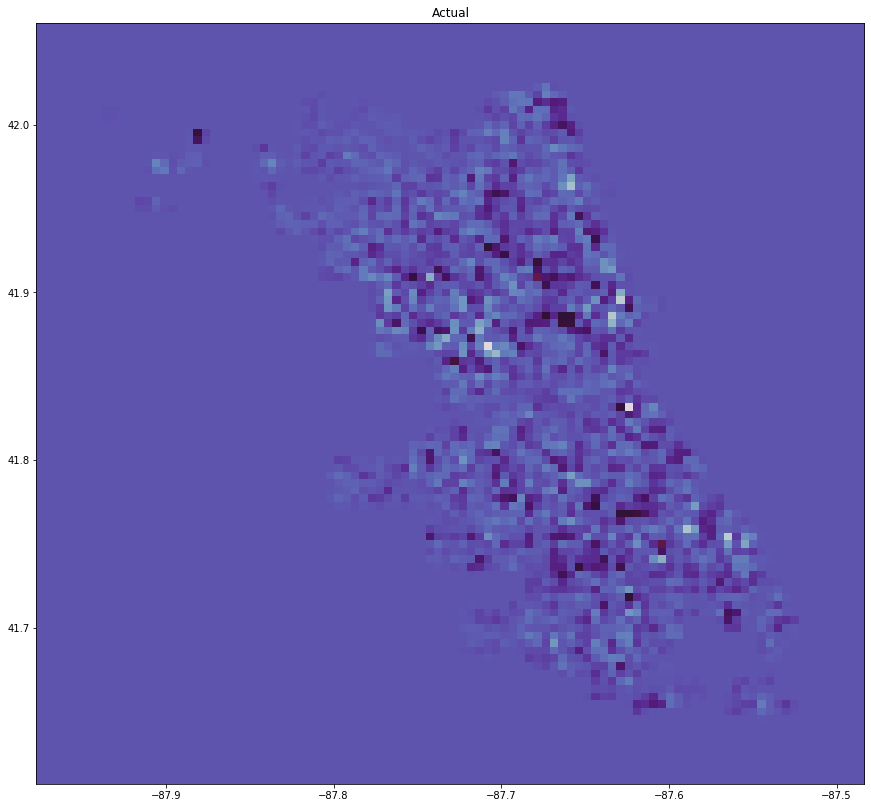

In [85]:
plt.figure(figsize=(18, 14))
plt.title('Actual')
plt.imshow( X=scaled_diff, cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])

#### Note the differences is scaled, red means extreme differences inplot above. Interestingly we see the extreme differences is at the highest crime areas.